# BRDF Correction Test

In [49]:
import datetime as dt
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
from path import Path
from matplotlib import pyplot

from sentinelhub import BBox, CRS, DataCollection, \
    get_image_dimension, MimeType, SentinelHubRequest, \
    SHConfig, WebFeatureService


from s2brdf import kernels, brdf


### Input data
We will obtain Sentinel 2 data for an area that covers several orbits using the Sentinel Hub Python API. The evalscript to obtain 

In [50]:
EVALSCRIPT = """
//VERSION=3

function setup() {
  return {
    input: [
      {
        bands: [
          "B08", "B03", "B02",
          "viewZenithMean", "viewAzimuthMean", "sunZenithAngles", "sunAzimuthAngles", "dataMask"
        ]
      }
    ],
    output: [
        {id: "default", bands: 7, sampleType: "FLOAT32", nodataValue: -9999}
    ]
  };
}

function evaluatePixel(sample) {
  if (sample.dataMask == 1) {
      return {
          default: [
            sample.B08,
            sample.B03,
            sample.B02,
            sample.viewZenithMean,
            sample.viewAzimuthMean,
            sample.sunZenithAngles,
            sample.sunAzimuthAngles
          ]
      };
  } else {
      return {
          default: [-9999, -9999, -9999, -9999, -9999, -9999, -9999]
      };
  };
}
"""


In [51]:
config = SHConfig(hide_credentials=True)
work_dir = Path('/tmp/brdf')

# define bbox for request
request_bbox = BBox(bbox=[-88.30, 31.97, -85.53, 32.85], crs=CRS.WGS84)

# send requests
orbit_dict = {
    83: '2021-05-07',
    40: '2021-05-09',
}
requests = {
    orbit: SentinelHubRequest(
        evalscript=EVALSCRIPT,
        data_folder=work_dir,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A,
                time_interval=[date, date]
            )
        ],
        responses=[
            SentinelHubRequest.output_response('default', MimeType.TIFF),
        ],
        bbox=request_bbox,
        size=(512, get_image_dimension(bbox=request_bbox, width=512)),
        config=config
    ) for orbit, date in orbit_dict.items()
}

for request in requests.values():
    request.save_data()


In [52]:
tifs = {
    orbit: work_dir / request.get_filename_list()[0] for orbit, request in requests.items()
}

# key for band name/indices
band_key = {
    'B08': 0,
    'B03': 1,
    'B02': 2,
    'vza': 3,
    'vaa': 4,
    'sza': 5,
    'saa': 6,
}


Read the rasters, replace -9999.0 with NA

In [53]:
with rasterio.open(tifs[40]) as src40, rasterio.open(tifs[83]) as src83:
    mosaic, trans = merge([src83, src40], nodata=-9999.0)



2021-09-13 10:03:39,209 - WARNING: CPLE_AppDefined in /tmp/brdf/8d53f9e68324b0d1e52476143bfdccfd/response.tiff: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2021-09-13 10:03:39,248 - WARNING: CPLE_AppDefined in /tmp/brdf/0c7fa7506f2bb48ce66af2a6c953c617/response.tiff: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2021-09-13 10:03:39,254 - WARNING: CPLE_AppDefined in TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
2021-09-13 10:03:39,287 - WARNING: CPLE_AppDefined in TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


For plotting the rasters, identify the 0.02 and 0.98 quantiles for each band for the min/max on RGB scale.

In [54]:
band_max = {
    band: np.nanquantile(mosaic[band], 0.98) for band in range(0, len(mosaic))
}
band_min = {
    band: np.nanquantile(mosaic[band], 0.02) for band in range(0, len(mosaic))
}


In [55]:
mosaic_scaled = mosaic.copy()
for band in [0, 1, 2]:
    mosaic_scaled[band] = (mosaic_scaled[band] - band_min[band]) / (band_max[band] - band_min[band])


2021-09-13 10:03:39,514 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


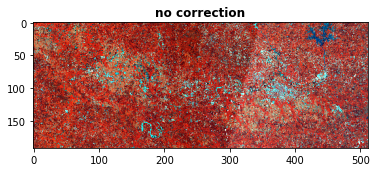

<AxesSubplot:title={'center':'no correction'}>

In [56]:
show(mosaic_scaled[[0, 1, 2]], adjust=None, title='no correction')


Notice the difference in brightness between the two images. This is what I am trying to correct.

## BRDF correction
Calculate the BRDF-adjusted reflectance using `brdf.calc_nbar`.

In [57]:
mosaic_nbar = mosaic.copy()
for band in ["B02", "B03", "B08"]:
    mosaic_nbar[band_key[band]] = brdf.calc_nbar(
        r_s2=mosaic_nbar[band_key[band]],
        band=band,
        sza=kernels.deg2rad(mosaic_nbar[band_key['sza']]),
        vza=kernels.deg2rad(mosaic_nbar[band_key['vza']]),
        saa=kernels.deg2rad(mosaic_nbar[band_key['saa']]),
        vaa=kernels.deg2rad(mosaic_nbar[band_key['vaa']])
    )

Apply same scale to the resulting images for plotting alongside originals.

In [58]:
mosaic_nbar_scaled = mosaic_nbar.copy()
for band in [0, 1, 2, 3]:
    mosaic_nbar_scaled[band] = (mosaic_nbar_scaled[band] - band_min[band]) / (band_max[band] - band_min[band])


2021-09-13 10:03:40,060 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


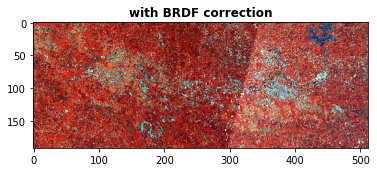

<AxesSubplot:title={'center':'with BRDF correction'}>

In [59]:
show(mosaic_nbar_scaled[[0, 1, 2]], adjust=None, title='with BRDF correction')


The corrections do not seem to have made much of a difference at this scale.

2021-09-13 10:03:40,426 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2021-09-13 10:03:40,433 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:title={'center':'with: BRDF correction'}>

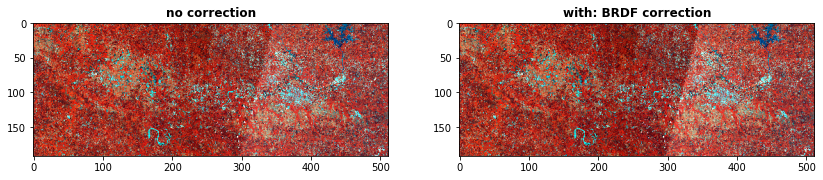

In [60]:
fig, (uncorrected, corrected) = pyplot.subplots(1, 2, figsize=(14, 7))
show(mosaic_scaled[[0, 1, 2]], adjust=None, ax=uncorrected, title='no correction')
show(mosaic_nbar_scaled[[0, 1, 2]], adjust=None, ax=corrected, title='with: BRDF correction')


Maybe something will jump out in the C-factor values?

In [61]:
c_lambda = brdf.calc_c_lambda(
    band="B04",
    sza=kernels.deg2rad(mosaic[band_key['sza']]),
    vza=kernels.deg2rad(mosaic[band_key['vza']]),
    saa=kernels.deg2rad(mosaic[band_key['saa']]),
    vaa=kernels.deg2rad(mosaic[band_key['vaa']])
)


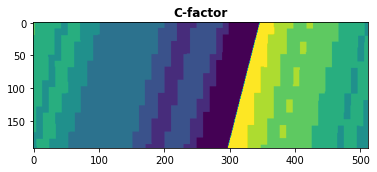

<AxesSubplot:title={'center':'C-factor'}>

In [62]:
c_lambda_scaled = np.int16(100 * c_lambda)

show(c_lambda_scaled, adjust=None, title='C-factor')


The C-factors are backwards from what I would assume... I expected the values on the west edge of the eastern orbit (40) to get adjusted down and the values on the east edge of the western orbit (83) to get adjusted up!